In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys 
import os
#import plotly.express as px
import pickle
import random 

sys.path.insert(0,"/home/mtissot/SpinUp/lib2")
import prepare as p1
import forecast as p2

import importlib
importlib.reload(p1)
importlib.reload(p2)


import importlib
import jumper
importlib.reload(jumper)
from jumper import Predictions, Simulation, load_ts

**A FAIRE**
- Predire les series temporelles independement 
- Afficher la prediction des trains sur la figure 
- Metrique de la densité
- Enregistrer les données

# **LOAD & PREPARE**

test SPINUP : 
SIMU_SU - 104 - 0 à 40

test NO SPINUP:
simu - 106 - 25 - 65

In [2]:
#from simu_path import path6 as path
#id_ = "106"
ye,start,end = True,25,70
ye = False
path ="/scratchu/mtissot/SIMUp6Y"

In [3]:
simu_zos    = Simulation(path=path,start=start,end=end,ye=ye,term="zos")    
print("zos loaded")
simu_so     = Simulation(path=path,start=start,end=end,ye=ye,term="so")   
print("so loaded")
simu_thetao = Simulation(path=path,start=start,end=end,ye=ye,term="thetao")   
print("thetao loaded")

#REMTTRE BIEN GET DATA APRES      return grid[:1] => return grid
simu_zos.prepare() 
print("\nzos prepared")
simu_so.prepare() 
print("so prepared")
simu_thetao.prepare() 
print("thetao prepared")


#LoadSimu : essayer avec des chunks plus gros et plus de jobs pour 3D 
#Prepare   : Cut spin Up - Remove Closed seas - Standardize - (old : Replace bathy nan values by the mean) - to float32

zos loaded
so loaded
thetao loaded

zos prepared
so prepared
thetao prepared


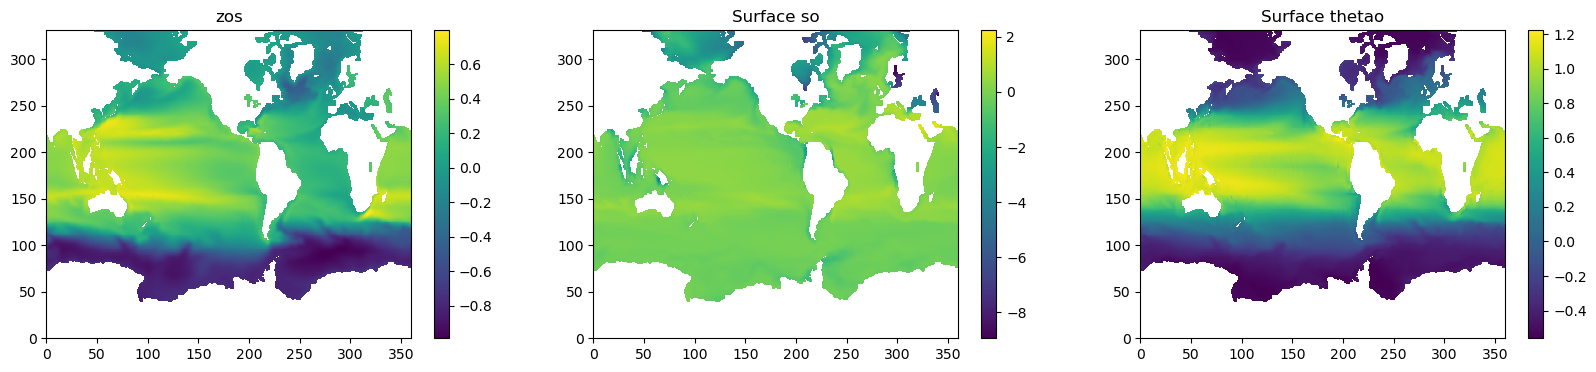

In [4]:
simus = [simu_zos,simu_so,simu_thetao]
names = ["zos","so","thetao"]

fig, axes = plt.subplots(1,len(simus), figsize=(20,4))

for i, simu in enumerate(simus):
    if simu.z_size is not None : 
        im = axes[i].pcolor(simu.simulation[0,0])
        axes[i].set_title(f"Surface {names[i]}")
    else:
        im = axes[i].pcolor(simu.simulation[0])
        axes[i].set_title(f"{names[i]}")
    plt.colorbar(im, ax=axes[i])

if False:
    fig, axes = plt.subplots(1,len(simus), figsize=(20,4))

    for i, simu in enumerate(simus):
        if simu.z_size is not None : 
            plt.plot(np.mean(simu.desc["ssca"],axis=(1,2,3)))
            axes[i].set_title(f"Average ssca - {names[i]}")
        else:
            plt.plot(np.mean(simu.desc["ssca"],axis=(1,2)))
            axes[i].set_title(f"Average ssca - {names[i]}")
    plt.colorbar(im, ax=axes[i])

# **TO TIME SERIES**

In [5]:
simu_zos.applyPCA()
print("PCA applied on zos")
simu_so.applyPCA()
print("PCA applied on so")
simu_thetao.applyPCA()
print("PCA applied on thetao")

PCA applied on zos
PCA applied on so
PCA applied on thetao


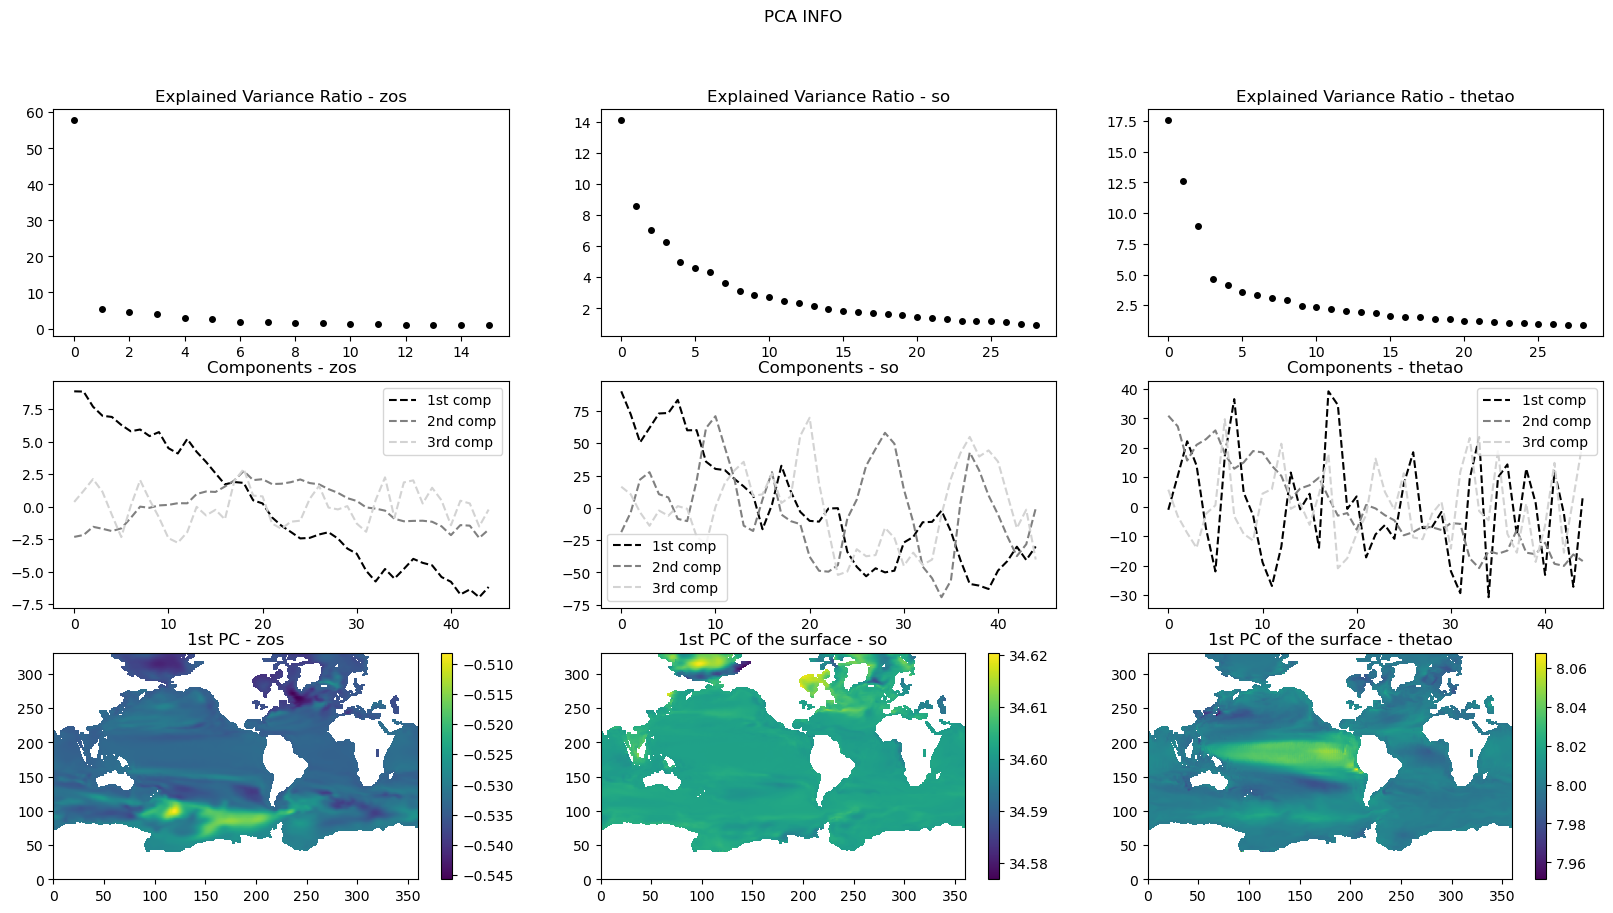

In [36]:
simus = [simu_zos,simu_so,simu_thetao]
names = ["zos","so","thetao"]
#units = ["m","°C","g/kg"]
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, simu in enumerate(simus):
    axes[0, i].plot(simu.pca.explained_variance_ratio_*100,"ko", markersize =4)
    axes[0, i].set_title(f"Explained Variance Ratio - {names[i]}")

    axes[1, i].plot(simu.components[:, 0], linestyle = "dashed", color="black", label="1st comp")
    axes[1, i].plot(simu.components[:, 1], linestyle = "dashed", color="grey", label="2nd comp")
    axes[1, i].plot(simu.components[:, 2], linestyle = "dashed", color="lightgrey", label="3rd comp")
    axes[1, i].set_title(f"Components - {names[i]}")
    axes[1, i].legend()
    
    if simu.z_size is not None : 
        im = axes[2, i].pcolor(simu.getPC(0)[0])
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC of the surface - {names[i]}")
    else:
        im = axes[2, i].pcolor(simu.getPC(0))
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC - {names[i]}")
        
fig.suptitle("PCA INFO")
plt.show()

In [7]:
n = len(simu_zos.pca.explained_variance_ratio_)
rec_zos,    rmseV_zos,    rmseM_zos    = simu_zos.rmseOfPCA(n)
print("RMSE compilated for zos")
n = len(simu_so.pca.explained_variance_ratio_)
rec_so,     rmseV_so,     rmseM_so     = simu_so.rmseOfPCA(n)
print("RMSE compilated for so")
n = len(simu_thetao.pca.explained_variance_ratio_)
rec_thetao, rmseV_thetao, rmseM_thetao = simu_thetao.rmseOfPCA(n)
print("RMSE compilated for thetao")

RMSE compilated for zos
RMSE compilated for so
RMSE compilated for thetao


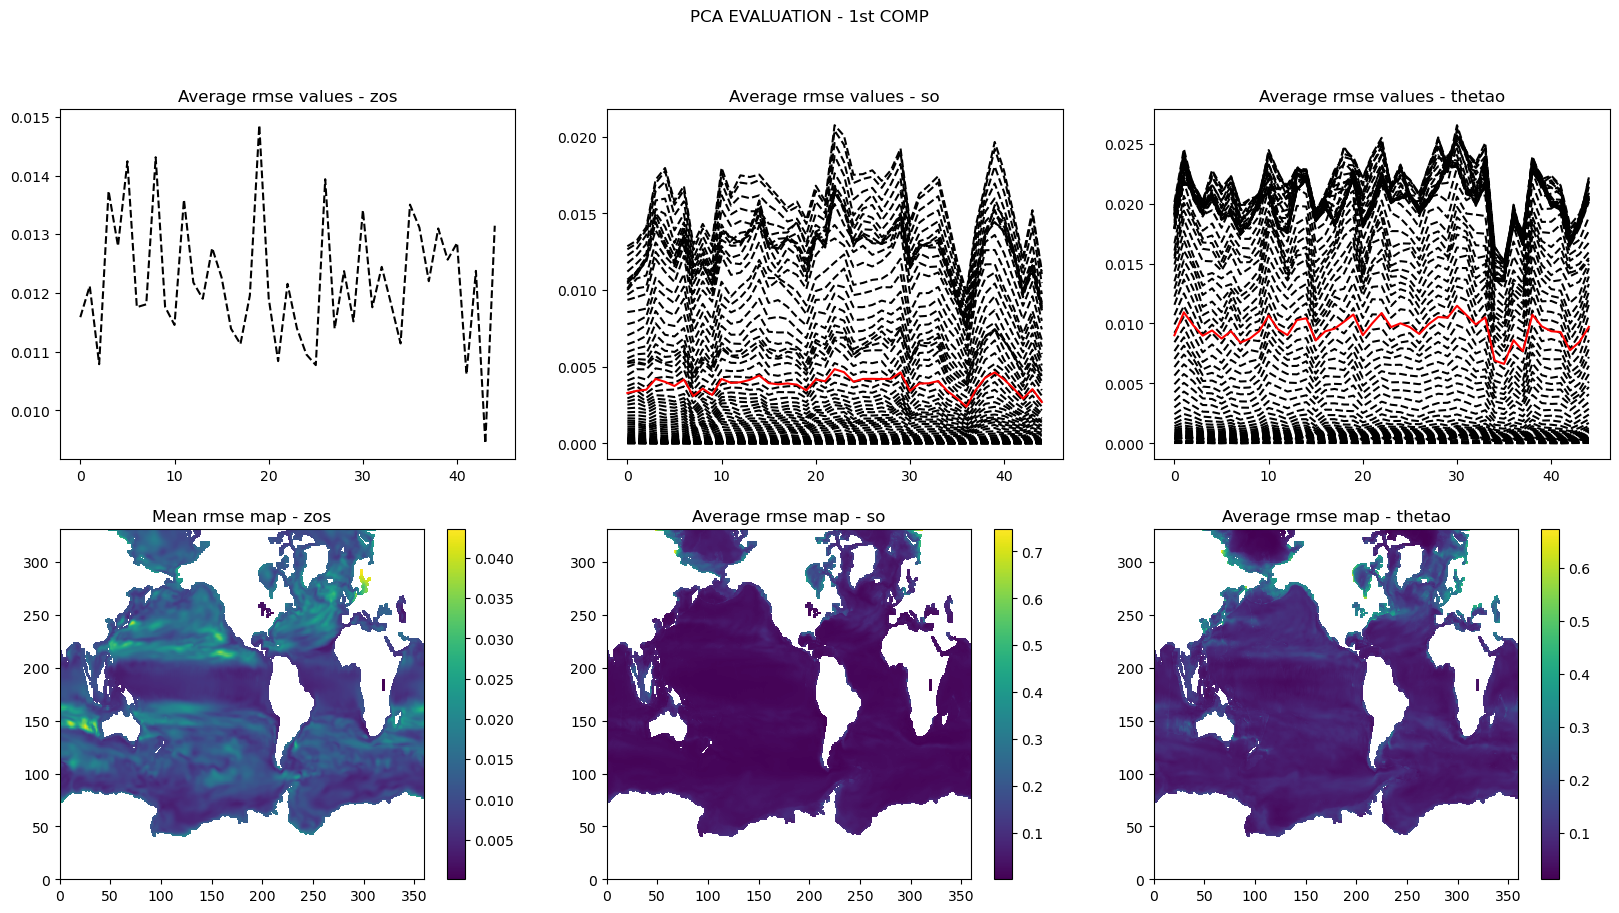

In [32]:
values = [rmseV_zos,rmseV_so,rmseV_thetao]
maps   = [rmseM_zos,rmseM_so,rmseM_thetao]
names  = ["zos","so","thetao"]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i in range(len(axes[0])):
    axes[0, i].plot(values[i],linestyle = "dashed",color="black", markersize =4)
    axes[0, i].set_title(f"Average rmse values - {names[i]}")

    if len(np.shape(maps[i]))==2: 
        im = axes[1, i].pcolor(maps[i])
        plt.colorbar(im, ax=axes[1, i])
        axes[1, i].set_title(f"Mean rmse map - {names[i]}")
    else:
        im = axes[1, i].pcolor(np.nanmean(maps[i],axis=0))
        plt.colorbar(im, ax=axes[1, i])
        axes[1, i].set_title(f"Average rmse map - {names[i]}")
        axes[0, i].plot(np.nanmean(values[i],axis=1),linewidth=1.5,color="red", markersize =4)
        
fig.suptitle("PCA EVALUATION - 1st COMP")
plt.show()

In [9]:
zos_dico = simu_zos.makeDico()
print("zos to dictionnary")
so_dico = simu_so.makeDico()
print("so to dictionnary")
thetao_dico = simu_thetao.makeDico()
print("thetao to dictionnary")

zos to dictionnary
so to dictionnary
thetao to dictionnary


In [10]:
f = "/data/mtissot/test_Forecast/simu_prepared/"
if not os.path.exists(f):
    os.makedirs(f)

with open(f + 'pca_so', 'wb') as file:
    pickle.dump(simu_so.pca, file)
with open(f + 'pca_thetao', 'wb') as file:
    pickle.dump(simu_thetao.pca, file)
with open(f + 'pca_zos', 'wb') as file:
    pickle.dump(simu_zos.pca, file)

np.savez(f + "so", **so_dico)
np.savez(f + "thetao", **thetao_dico)
np.savez(f + "zos", **zos_dico)


# **FORECAST**

In [11]:
f = "/data/mtissot/test_Forecast/simu_prepared/"

df_zos,infos_zos       = load_ts(f,"zos")
df_so,infos_so         = load_ts(f,"so")
df_thetao,infos_thetao = load_ts(f,"thetao")

random.seed(20)

ts_zos    = Predictions("zos",df_zos,infos_zos)  
ts_so     = Predictions("so",df_so,infos_so)  
ts_thetao = Predictions("thetao",df_thetao,infos_thetao)  

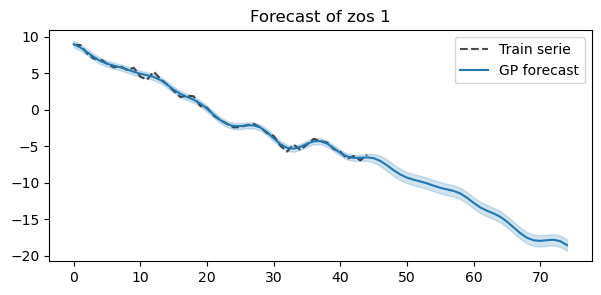

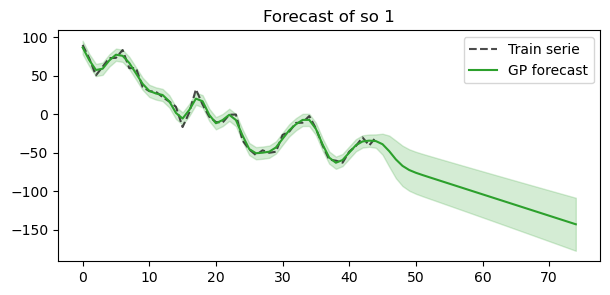

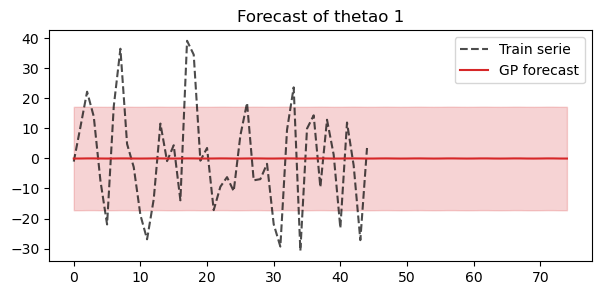

In [12]:
comp,train_len,steps=1,len(ts_zos),30#,20#len(ts_zos),30

hat_zos,    std_zos,    metrics_zos    = ts_zos.forecast_ts(comp,train_len,steps)
hat_so,     std_so,     metrics_so     = ts_so.forecast_ts(comp,train_len,steps)
hat_thetao, std_thetao, metrics_thetao = ts_thetao.forecast_ts(comp,train_len,steps)

ts_zos.show(comp,hat_zos,std_zos,train_len)
ts_so.show(comp,hat_so,std_so,train_len,color="tab:green")
ts_thetao.show(comp,hat_thetao,std_thetao,train_len,color="tab:red")

In [13]:
hat_zos,    hat_std_zos,    metrics = ts_zos.Forecast(train_len,steps)
hat_so,     hat_std_so,     metrics = ts_so.Forecast(train_len,steps)
hat_thetao, hat_std_thetao, metrics = ts_thetao.Forecast(train_len,steps)

In [14]:
predictions_zos1     = ts_zos.reconstruct(hat_zos,1)
print("zos reconstructed with one comp")
predictions_so1      = ts_so.reconstruct(hat_so,1)
print("so reconstructed with one comp")
predictions_thetao1  = ts_thetao.reconstruct(hat_thetao,1)
print("thetao reconstructed with one comp")

zos reconstructed with one comp
so reconstructed with one comp
thetao reconstructed with one comp


In [15]:
predictions_zos2     = ts_zos.reconstruct(hat_zos,2)
print("zos reconstructed with two comp")
predictions_so2      = ts_so.reconstruct(hat_so,2)
print("so reconstructed with two comp")
predictions_thetao2  = ts_thetao.reconstruct(hat_thetao,2)
print("thetao reconstructed with two comp")

zos reconstructed with two comp
so reconstructed with two comp
thetao reconstructed with two comp


In [16]:
n = np.shape(ts_zos.info["ts"])[1]
predictions_zos     = ts_zos.reconstruct(hat_zos,n)
print("zos reconstructed with all comp")
n = np.shape(ts_so.info["ts"])[1]
predictions_so      = ts_so.reconstruct(hat_so,n)
print("so reconstructed with all comp")
n = np.shape(ts_thetao.info["ts"])[1]
predictions_thetao  = ts_thetao.reconstruct(hat_thetao,n)
print("thetao reconstructed with all comp")

zos reconstructed with all comp
so reconstructed with all comp
thetao reconstructed with all comp


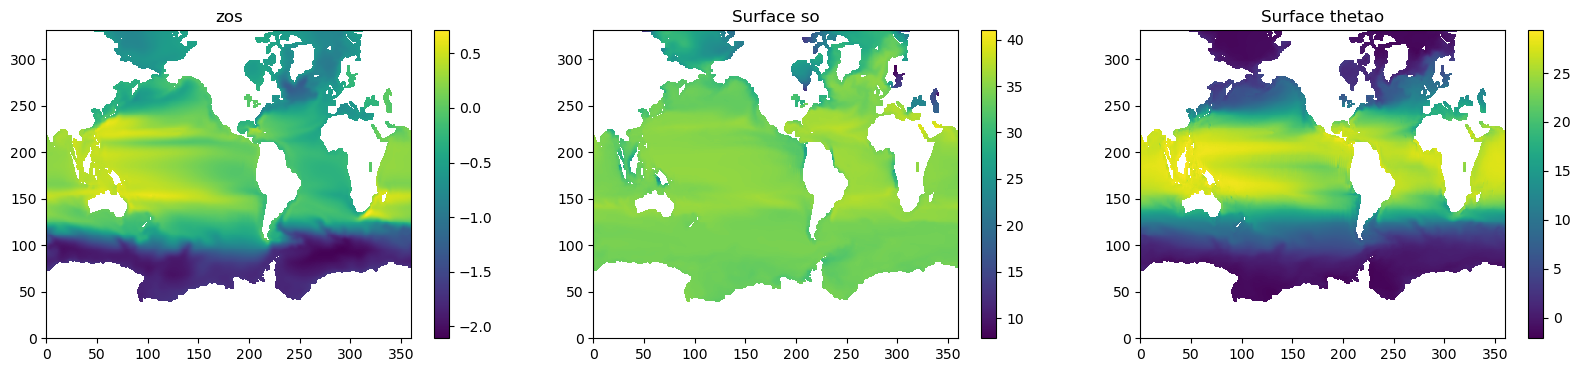

In [17]:
maps  = [predictions_zos,predictions_so,predictions_thetao]
names = ["zos","so","thetao"]

fig, axes = plt.subplots(1,len(maps), figsize=(20,4))

for i, simu in enumerate(maps):
    if len(np.shape(simu)) > 3 : 
        im = axes[i].pcolor(simu[0,0])
        axes[i].set_title(f"Surface {names[i]}")
    else:
        im = axes[i].pcolor(simu[0])
        axes[i].set_title(f"{names[i]}")
    plt.colorbar(im, ax=axes[i])


In [18]:
#predictions_zos2    = np.load("/data/mtissot/simus_predicted/zos.npy")
#predictions_so2     = np.load("/data/mtissot/simus_predicted/so.npy")
#predictions_thetao2 = np.load("/data/mtissot/simus_predicted/thetao.npy")

# **EVALUATE ERROR**

In [19]:
import importlib
import jumper
importlib.reload(p1)
from jumper import Predictions, Simulation, load_ts

In [21]:
start2,end2 = 25,70+30#start,end+steps
id_ = "106"
ye = False
path ="/scratchu/mtissot/SIMUp6Y"
simu_zos2 = Simulation(path=path,start=start2,end=end2,ye=ye,term="zos")    
print("zos loaded")
simu_so2  = Simulation(path=path,start=start2,end=end2,ye=ye,term="so")   
print("so loaded")
simu_thetao2 = Simulation(path=path,start=start2,end=end2,ye=ye,term="thetao")   
print("thetao loaded")

#REMTTRE BIEN GET DATA APRES      return grid[:1] => return grid
simu_zos2.prepare(stand=False) 
print("\nzos prepared")
simu_so2.prepare(stand=False) 
print("so prepared")
simu_thetao2.prepare(stand=False) 
print("thetao prepared")

zos loaded
so loaded
thetao loaded

zos prepared
so prepared
thetao prepared


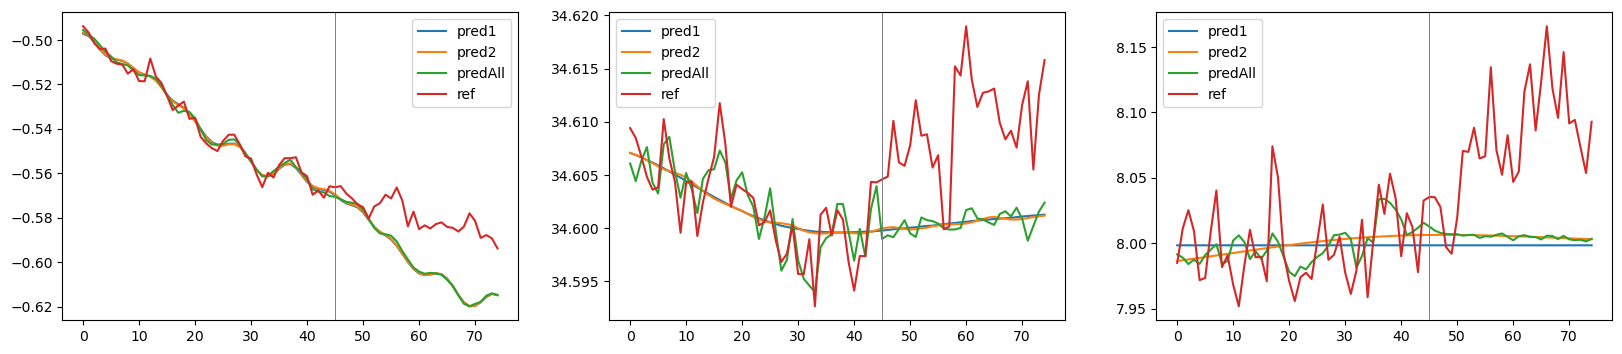

In [31]:
fig, axes = plt.subplots(1,3, figsize=(20,4))

axes[0].plot(np.nanmean(predictions_zos1,axis=(1,2)),label="pred1")
axes[0].plot(np.nanmean(predictions_zos2,axis=(1,2)),label="pred2")
axes[0].plot(np.nanmean(predictions_zos,axis=(1,2)),label="predAll")
axes[0].plot(np.nanmean(simu_zos2.simulation[:],axis=(1,2)),label="ref")
axes[0].axvline(train_len, color="grey",linewidth=0.7)
axes[0].legend()

axes[1].plot(np.nanmean(predictions_so1,axis=(1,2,3)),label="pred1")
axes[1].plot(np.nanmean(predictions_so2,axis=(1,2,3)),label="pred2")
axes[1].plot(np.nanmean(predictions_so,axis=(1,2,3)),label="predAll")
axes[1].plot(np.nanmean(simu_so2.simulation[:],axis=(1,2,3)),label="ref")
axes[1].axvline(train_len, color="grey",linewidth=0.7)
axes[1].legend()

axes[2].plot(np.nanmean(predictions_thetao1,axis=(1,2,3)),label="pred1")
axes[2].plot(np.nanmean(predictions_thetao2,axis=(1,2,3)),label="pred2")
axes[2].plot(np.nanmean(predictions_thetao,axis=(1,2,3)),label="predAll")
axes[2].plot(np.nanmean(simu_thetao2.simulation[:],axis=(1,2,3)),label="ref")
axes[2].axvline(train_len, color="grey",linewidth=0.7)
axes[2].legend()

In [26]:
simu_zos2.applyPCA()
print("PCA applied on zos")
simu_so2.applyPCA()
print("PCA applied on so")
simu_thetao2.applyPCA()
print("PCA applied on thetao")

PCA applied on zos
PCA applied on so
PCA applied on thetao


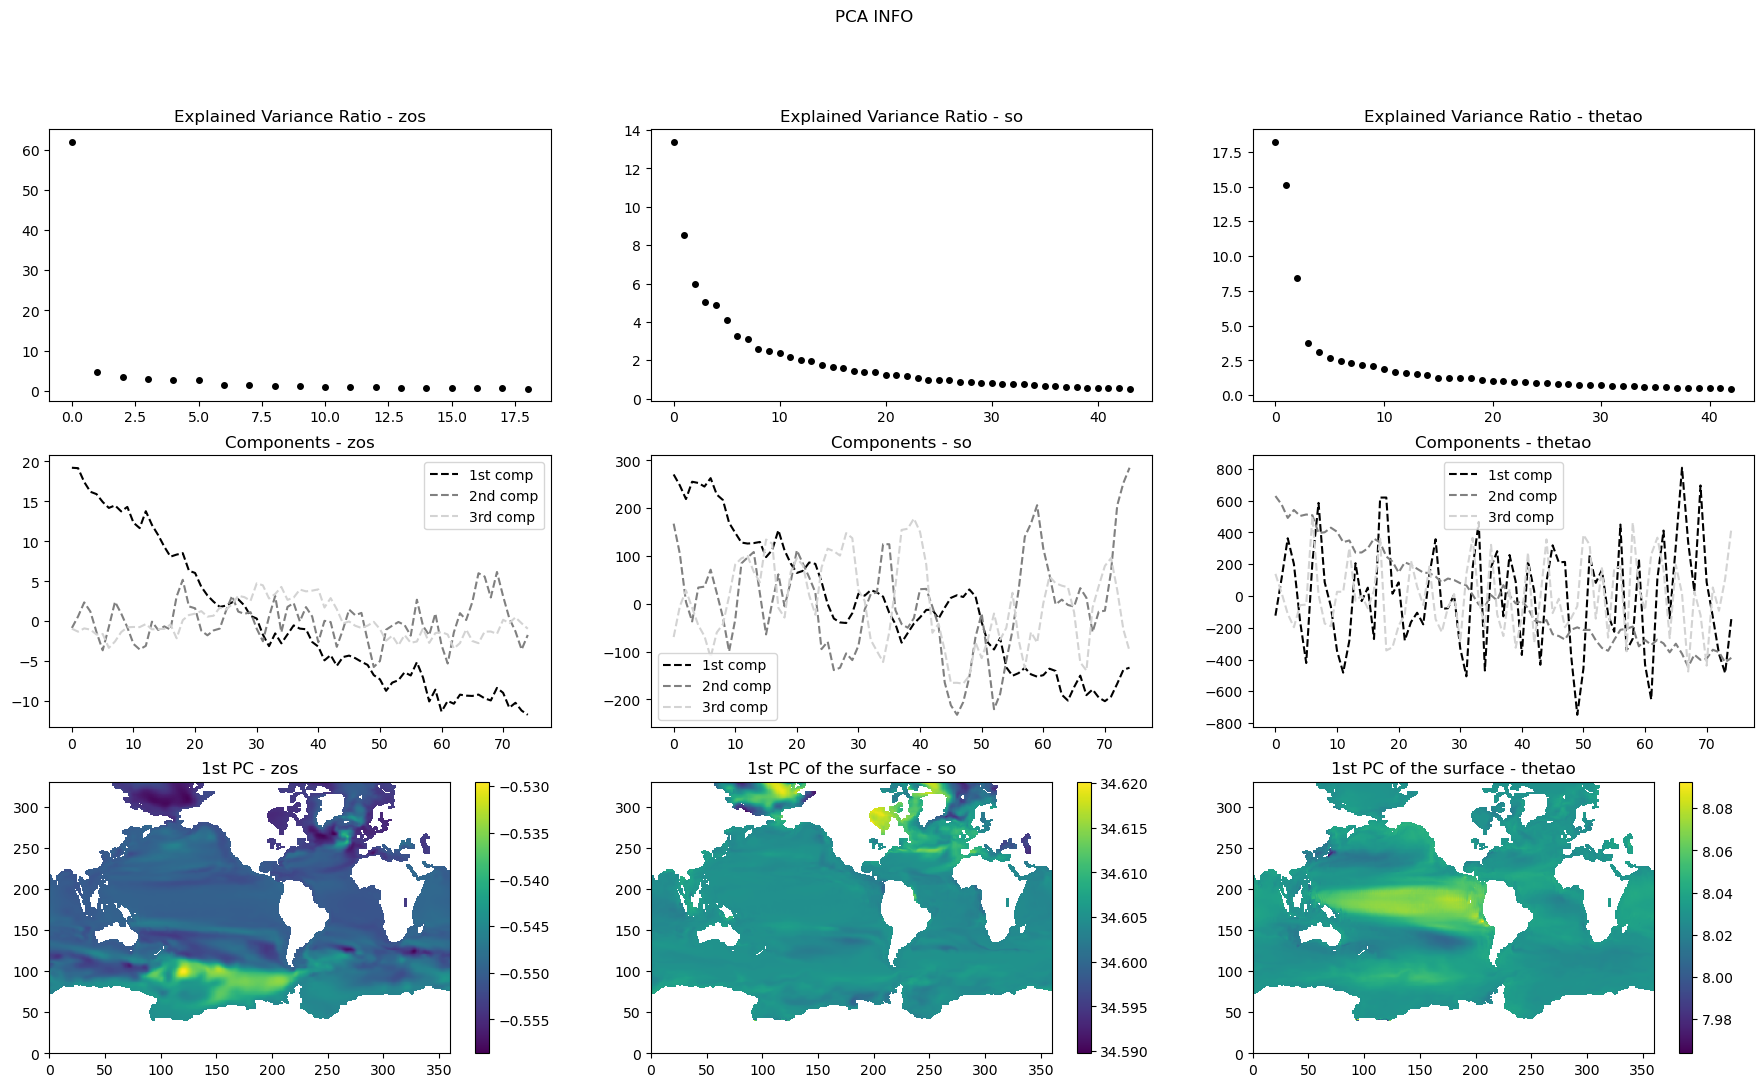

In [27]:
simus = [simu_zos2,simu_so2,simu_thetao2]
names = ["zos","so","thetao"]
#units = ["m","°C","g/kg"]
fig, axes = plt.subplots(3, 3, figsize=(22, 12))

for i, simu in enumerate(simus):
    axes[0, i].plot(simu.pca.explained_variance_ratio_*100,"ko", markersize =4)
    axes[0, i].set_title(f"Explained Variance Ratio - {names[i]}")

    axes[1, i].plot(simu.components[:, 0], linestyle = "dashed", color="black", label="1st comp")
    axes[1, i].plot(simu.components[:, 1], linestyle = "dashed", color="grey", label="2nd comp")
    axes[1, i].plot(simu.components[:, 2], linestyle = "dashed", color="lightgrey", label="3rd comp")
    axes[1, i].set_title(f"Components - {names[i]}")
    axes[1, i].legend()
    
    if simu.z_size is not None : 
        im = axes[2, i].pcolor(simu.getPC(0)[0])
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC of the surface - {names[i]}")
    else:
        im = axes[2, i].pcolor(simu.getPC(0))
        plt.colorbar(im, ax=axes[2, i])#,label=units[i])
        axes[2, i].set_title(f"1st PC - {names[i]}")
        
fig.suptitle("PCA INFO")
plt.show()

In [28]:
def getRmseV(s,p,steps):
    n = np.product(s.shape) - np.nansum(np.isnan(s.simulation[0]))
    c = np.sqrt(np.nansum(np.nansum((s.simulation[-steps:]-p[-steps:])**2,axis=-1),axis=-1)/n)
    return c# * 2 * s.desc["std"]

def rmseMap(s,p,window):
    t = s.len
    return np.sqrt(np.sum((s.simulation[-window:]-p[-window:])**2,axis=0)/t) #* 2 * s.desc["std"]

In [29]:
rmseV_zos2    = getRmseV(simu_zos2,predictions_zos,30)
rmseV_so2     = getRmseV(simu_so2,predictions_so,30)
rmseV_thetao2 = getRmseV(simu_thetao2,predictions_thetao,30)

rmseM_zos2    = rmseMap(simu_zos2,predictions_zos,3)
rmseM_so2     = rmseMap(simu_so2,predictions_so,3)
rmseM_thetao2 = rmseMap(simu_thetao2,predictions_thetao,3)

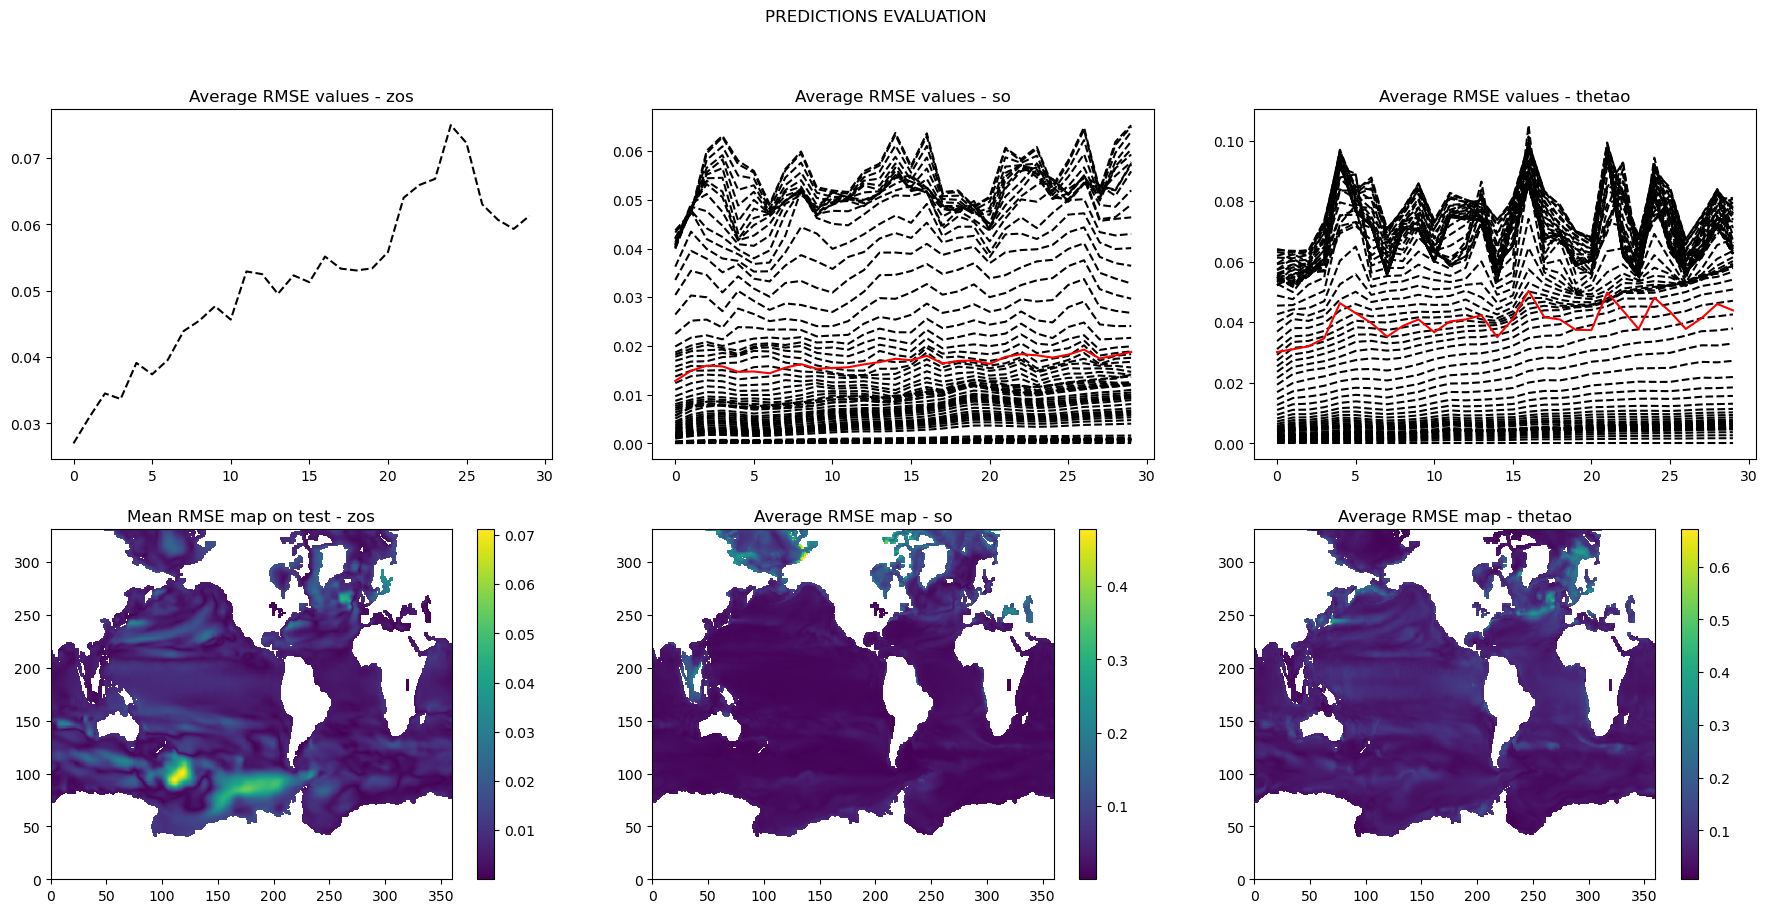

In [30]:
values = [rmseV_zos2, rmseV_so2, rmseV_thetao2]
maps   = [rmseM_zos2, rmseM_so2, rmseM_thetao2]
names  = ["zos", "so", "thetao"]

fig, axes = plt.subplots(2, 3, figsize=(22, 10))

for i in range(len(axes[0])):
    axes[0, i].plot(values[i], linestyle="dashed", color="black", markersize=4)
    #axes[0, i].axvline(train_len,color="black",alpha=0.5,linewidth=0.6,label='train limit')
    #axes[0, i].legend()
    axes[0, i].set_title(f"Average RMSE values - {names[i]}")

    if len(np.shape(maps[i])) > 2:
        axes[0, i].plot(np.nanmean(values[i], axis=1), linewidth=1.5, color="red", markersize=4)
        im = axes[1, i].pcolor(np.nanmean(maps[i], axis=0))
        plt.colorbar(im, ax=axes[1, i])
        axes[1, i].set_title(f"Average RMSE map - {names[i]}")
    else:
        im = axes[1, i].pcolor(maps[i])
        plt.colorbar(im, ax=axes[1, i])
        axes[1, i].set_title(f"Mean RMSE map on test - {names[i]}")

fig.suptitle("PREDICTIONS EVALUATION")
plt.show()

# **SAVE PREDICTIONS**

In [92]:
np.save("/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/simu_SU/pred_zos.npy", predictions_zos)
np.save("/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/simu_SU/pred_so.npy", predictions_so)
np.save("/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/simu_SU/pred_thetao.npy", predictions_thetao)

In [29]:
import xarray as xr
xarray_zos = xr.DataArray(predictions_zos, dims=("time_counter", "y", "x"), name="zos")
xarray_so = xr.DataArray(predictions_so, dims=("time_counter", "deptht", "y", "x"), name="so")
xarray_so = xr.DataArray(predictions_thetao, dims=("time_counter", "deptht", "y", "x"), name="thetao")

In [26]:
xarray_zos     = addClosedSeas(xarray_zos)
xarray_so      = addClosedSeas(xarray_so)
xarray_thetao  = addClosedSeas(xarray_thetao)

In [50]:
#xr.to_netcdf("/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/predictions/Pred_106_60_90/zos.nc")

- Time serie

In [ ]:
simu_zos2.applyPCA()
print("PCA applied on zos")
simu_so2.applyPCA()
print("PCA applied on so")
simu_thetao2.applyPCA()
print("PCA applied on thetao")

PCA applied on zos
PCA applied on so
PCA applied on thetao


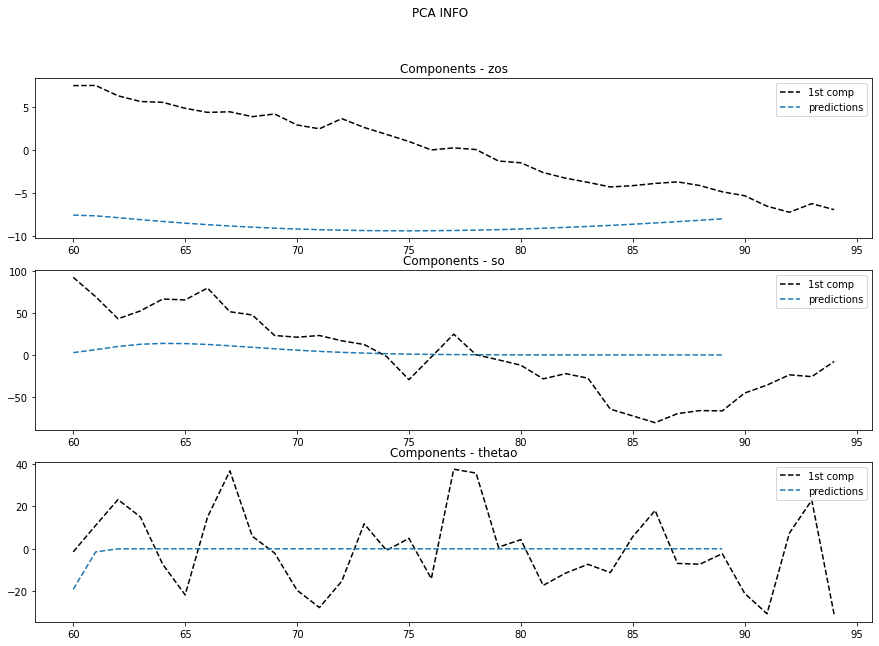

In [195]:
import matplotlib.pyplot as plt

simus = [simu_zos2, simu_so2, simu_thetao2]
preds = [hat_zos,hat_so,hat_thetao]
names = ["zos", "so", "thetao"]

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, simu in enumerate(simus):
    axes[i].plot(np.arange(end,end+35),simu.components[:, 0], linestyle="dashed", color="black", label="1st comp")
    axes[i].plot(np.arange(end,end+30), preds[i],linestyle="dashed", color="tab:blue", label="predictions")
    axes[i].set_title(f"Components - {names[i]}")
    axes[i].legend()

# Set a common title for all subplots
fig.suptitle("PCA INFO")
plt.show()


# **PHYSICAL METRICS**

In [ ]:
simus = [simu_zos2,simu_so2,simu_thetao2]
names = ["zos","so","thetao"]

fig, axes = plt.subplots(1,len(simus), figsize=(20,4))

for i, simu in enumerate(simus):
    if simu.z_size is not None : 
        im = axes[i].pcolor(simu.simulation[0,0])
        axes[i].set_title(f"Surface {names[i]}")
    else:
        im = axes[i].pcolor(simu.simulation[0])
        axes[i].set_title(f"{names[i]}")
    plt.colorbar(im, ax=axes[i])

if False:
    print()
    fig, axes = plt.subplots(1,len(simus), figsize=(20,4))

    for i, simu in enumerate(simus):
        if simu.z_size is not None : 
            plt.plot(np.mean(simu.desc["ssca"],axis=(1,2,3)))
            axes[i].set_title(f"Average ssca - {names[i]}")
        else:
            plt.plot(np.mean(simu.desc["ssca"],axis=(1,2)))
            axes[i].set_title(f"Average ssca - {names[i]}")
    plt.colorbar(im, ax=axes[i])

In [77]:
rau0 = 10e3
def insitu(theta0,S,Z):
    rho = rau0 * insitu_anom(theta0,S,Z) + rau0
    return rho

def insitu_anom(theta0,S,Z):    
    zsr=np.sqrt(np.abs(S))
    zt=theta0
    zs=S
    zh=Z
    # compute volumic mass pure water at atm pressure
    zr1 = ((((6.536332e-9*zt-1.120083e-6)*zt+1.001685e-4)*zt-9.095290e-3)*zt+6.793952e-2)*zt+999.842594
    # seawater volumic mass atm pressure
    zr2 = (((5.3875e-9*zt-8.2467e-7)*zt+7.6438e-5)*zt-4.0899e-3)*zt+0.824493
    zr3 = (-1.6546e-6*zt+1.0227e-4)*zt-5.72466e-3
    zr4 = 4.8314e-4

    # potential volumic mass (reference to the surface)
    zrhop = (zr4*zs+zr3*zsr+zr2)*zs+zr1

    # add the compression terms
    ze = (-3.508914e-8*zt-1.248266e-8)*zt-2.595994e-6
    zbw= (1.296821e-6*zt-5.782165e-9)*zt+1.045941e-4
    zb = zbw+ze*zs

    zd = -2.042967e-2
    zc = (-7.267926e-5*zt+2.598241e-3)*zt+0.1571896
    zaw= ((5.939910e-6*zt+2.512549e-3)*zt-0.1028859)*zt-4.721788
    za = (zd*zsr+zc)*zs+zaw

    zb1= (-0.1909078*zt+7.390729)*zt-55.87545
    za1= (( 2.326469e-3*zt+1.553190)*zt-65.00517 )*zt+1044.077
    zkw= (((-1.361629e-4*zt-1.852732e-2)*zt-30.41638 )*zt+2098.925)*zt+190925.6
    zk0= (zb1*zsr+za1 )*zs+zkw

    prd=( zrhop / (  1.0 - zh / ( zk0 - zh * ( za - zh * zb ) )  ) - rau0 ) / rau0

    return prd

In [81]:
import xarray as xr
f = "/scratchu/mtissot/SIMUp6Y/CM65v420-LR-CdL-pi-01_18500101_19491231_1M_so.nc.YAVG.nc"
array = xr.open_dataset(f, decode_times=False)#,chunks={"time": 200, "x":120})
depth = array.deptht.values
depth = np.tile(depth, (2,360,331,1)).transpose(0,3,2,1)
np.shape(depth)

test = insitu(simu_thetao2.simulation[-1],simu_so2.simulation[-1],10e-3)

In [82]:
MASKdataset = xr.open_dataset('/thredds/idris/work/ues27zx/eORCA1.4.2_mesh_mask_modJD.nc',decode_times=False)
e3t = MASKdataset["e3t_0"].values[0]
diff = np.diff(test, axis=0)/e3t[:-1]  #rho_insitu  #rho0
#for i in range(0,331,25):
#    for j in range(0,360,25):
#        plt.plot(diff[:,i,j])

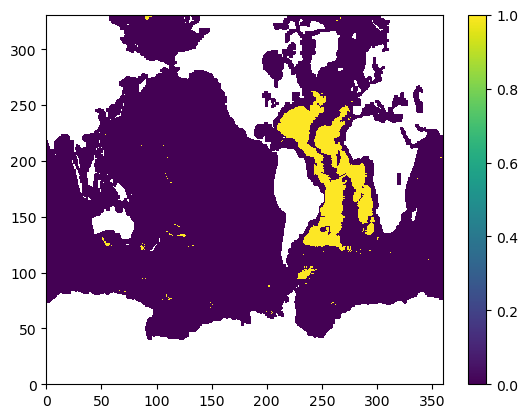

In [86]:
import numpy as np
import matplotlib.pyplot as plt

c = np.isnan(simu_zos2.simulation[0])  # Boolean array indicating NaN values
alpha_values = np.where(c, 0, 1.0)  # Set transparency to 0.5 where NaN, otherwise 1.0

plt.pcolor(np.nanmin(diff, axis=0) < 0, alpha=alpha_values)  # Plot with transparency
plt.colorbar()
plt.show()

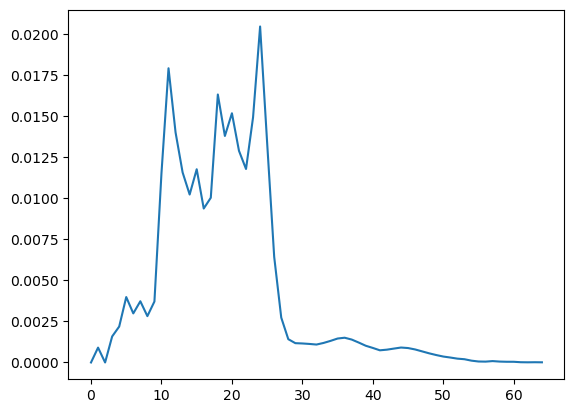

In [89]:
plt.plot(diff[:,248,150])